In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import seaborn as sns
import plotly.express as px
import cv2 # pip install opencv-python

In [2]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=784):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        x = F.relu(self.decoder_layer_1(z))
        reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        
        return reconstruction, mu, log_var
    
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [3]:
class AutoencoderDataset(Dataset):         
    def __init__(self, x):    
        self.x = x

        self.n_samples = len(x)
                                                                  
    def __getitem__(self, index):                   
        return self.x[index], self.x[index]                
                                                     
    def __len__(self):                                                                                   
        return self.n_samples

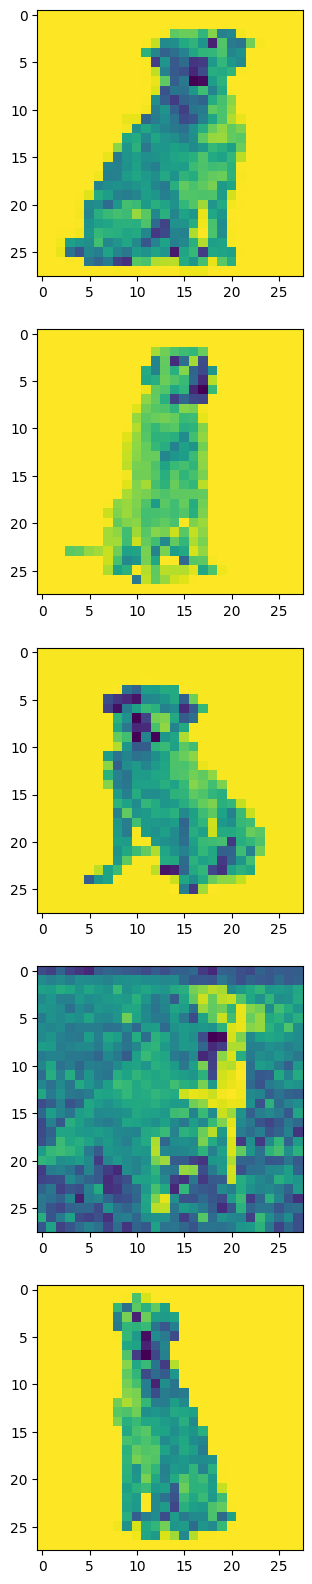

In [4]:
img_width = 28
img_height = 28

dim = (img_width, img_height)

doggos = [
    "./images/labrador1.jpg",
    "./images/labrador2.jpg",
    "./images/labrador3.jpg",
    "./images/labrador4.jpg",
    "./images/labrador5.jpg"
]

images = []

for doggo in doggos:
    img = cv2.imread(doggo, 0) / 255 # read as grayscale 1 channel images and normalize
    
    img = cv2.resize(img, dim)
    
    images.append(img)

num_images = len(images)
num_cols   = 1

col_names = [
    "Original"
]

fig, axes = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(num_cols*4, num_images*4))
counter = 0

for img in images:
    counter += 1
    
    plt.subplot(len(images), num_cols, counter)
    plt.imshow(img)

In [5]:
data = []

for img in images:
    data.append(img.ravel())
    
np.array(data).shape

(5, 784)

In [6]:
x = torch.Tensor(np.array(data))

x

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
        [0.2443, 0.2061, 0.3351,  ..., 0.2155, 0.3502, 0.2604],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [7]:
device = 'cpu'
learning_rate = 0.001
epochs = 100
batch_size = 1
num_features=8
num_dim=784

model = VariationalAutoencoder(num_features=num_features, num_dim=num_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

In [8]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
train_ds = AutoencoderDataset(
    x=x
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [10]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    ave_loss = 0.0
    count = 0

    for batch_idx, (data, targets) in enumerate(loop):
        data    = data.to(device=device)
        targets = targets.to(device=device)

        # Backward
        optimizer.zero_grad()
        
        reconstruction, mu, logvar = model.forward(data)
        
        bce_loss = criterion(reconstruction, data)
        
        loss = final_loss(bce_loss, mu, logvar)

        loss.backward()

        optimizer.step()

        # update tqdm
        loop.set_postfix(loss=loss.item())

        ave_loss += loss.item()
        count += 1

    ave_loss = ave_loss / count

    return ave_loss

In [11]:
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    ave_loss = train_fn(train_loader, model, optimizer, final_loss)
    print("Ave Loss: {}".format(ave_loss))

    state = {
        'state_dict':       model.state_dict(),
        'optimizer':        optimizer.state_dict()
    }
    
    torch.save(state, "autoencoder.pth")
    
    losses.append(ave_loss)

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.35it/s, loss=439]


Ave Loss: 524.3477478027344
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 273.22it/s, loss=288]


Ave Loss: 409.97113647460935
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 251.90it/s, loss=219]


Ave Loss: 368.14063415527346
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 255.14it/s, loss=264]


Ave Loss: 330.8469299316406
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 273.79it/s, loss=224]


Ave Loss: 327.30137634277344
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 215.61it/s, loss=225]


Ave Loss: 346.5554504394531
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 244.14it/s, loss=211]


Ave Loss: 406.18028564453124
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.18it/s, loss=219]


Ave Loss: 317.9544342041016
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 209.66it/s, loss=206]


Ave Loss: 311.25843200683596
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 234.33it/s, loss=219]


Ave Loss: 310.9123291015625
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 234.52it/s, loss=217]


Ave Loss: 305.17392883300784
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 217.84it/s, loss=212]


Ave Loss: 308.44598083496095
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 180.60it/s, loss=207]


Ave Loss: 326.3740997314453
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 215.09it/s, loss=214]


Ave Loss: 340.6322418212891
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 241.74it/s, loss=203]


Ave Loss: 309.6358612060547
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 268.31it/s, loss=194]


Ave Loss: 292.6518035888672
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 236.57it/s, loss=191]


Ave Loss: 286.71430053710935
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 197.48it/s, loss=189]


Ave Loss: 284.12669372558594
Epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 182.57it/s, loss=193]


Ave Loss: 303.5226135253906
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 205.51it/s, loss=193]


Ave Loss: 286.33933715820314
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 219.90it/s, loss=193]


Ave Loss: 283.4308349609375
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 202.48it/s, loss=190]


Ave Loss: 279.99786376953125
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 237.20it/s, loss=191]


Ave Loss: 274.47637329101565
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 209.44it/s, loss=181]


Ave Loss: 268.34588317871095
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.22it/s, loss=190]


Ave Loss: 284.9853942871094
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 251.61it/s, loss=223]


Ave Loss: 279.3254669189453
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 240.54it/s, loss=183]


Ave Loss: 270.16847534179686
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 199.52it/s, loss=192]


Ave Loss: 275.3318817138672
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 208.52it/s, loss=186]


Ave Loss: 276.88172912597656
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 207.40it/s, loss=192]


Ave Loss: 269.2437744140625
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 210.81it/s, loss=189]


Ave Loss: 288.2469085693359
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 224.42it/s, loss=190]


Ave Loss: 270.72337036132814
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 223.12it/s, loss=182]


Ave Loss: 270.5831817626953
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 199.34it/s, loss=175]


Ave Loss: 275.2524841308594
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 214.92it/s, loss=194]


Ave Loss: 267.34685668945315
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 273.94it/s, loss=184]


Ave Loss: 275.3952392578125
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 235.85it/s, loss=182]

Ave Loss: 267.00486755371094


Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 163.37it/s, loss=185]


Ave Loss: 267.5013885498047
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 173.23it/s, loss=194]


Ave Loss: 268.1529937744141
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 191.17it/s, loss=185]


Ave Loss: 265.8628753662109
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 187.98it/s, loss=181]


Ave Loss: 269.5801177978516
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 202.92it/s, loss=179]


Ave Loss: 259.52056884765625
Epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 181.65it/s, loss=178]


Ave Loss: 261.87965698242186
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 247.43it/s, loss=193]

Ave Loss: 270.473681640625


Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 210.77it/s, loss=177]


Ave Loss: 268.2469970703125
Epoch: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 203.72it/s, loss=183]


Ave Loss: 270.717138671875
Epoch: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 192.61it/s, loss=178]


Ave Loss: 265.07383117675784
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 168.48it/s, loss=177]


Ave Loss: 255.45310974121094
Epoch: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 187.31it/s, loss=184]

Ave Loss: 257.4909698486328


Epoch: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.56it/s, loss=175]

Ave Loss: 254.43511047363282


Epoch: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 215.77it/s, loss=173]

Ave Loss: 252.9663330078125


Epoch: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 181.14it/s, loss=174]

Ave Loss: 251.68614196777344


Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 174.53it/s, loss=171]

Ave Loss: 250.25283508300782


Epoch: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 225.20it/s, loss=170]

Ave Loss: 249.7955078125


Epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 252.98it/s, loss=174]


Ave Loss: 253.21264038085937
Epoch: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 261.61it/s, loss=176]


Ave Loss: 254.315283203125
Epoch: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 223.95it/s, loss=171]


Ave Loss: 253.95912475585936
Epoch: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 226.37it/s, loss=183]


Ave Loss: 252.36473083496094
Epoch: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.88it/s, loss=171]

Ave Loss: 258.0279937744141


Epoch: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 244.64it/s, loss=193]

Ave Loss: 254.39877014160157


Epoch: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 226.22it/s, loss=169]

Ave Loss: 244.8419647216797


Epoch: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 226.59it/s, loss=165]

Ave Loss: 248.54932556152343


Epoch: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 224.20it/s, loss=160]


Ave Loss: 248.93875732421876
Epoch: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.58it/s, loss=170]


Ave Loss: 255.0361755371094
Epoch: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 198.50it/s, loss=181]


Ave Loss: 249.86615600585938
Epoch: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 190.80it/s, loss=184]


Ave Loss: 249.01048278808594
Epoch: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 249.02it/s, loss=168]


Ave Loss: 249.63084106445314
Epoch: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.96it/s, loss=165]


Ave Loss: 245.71651611328124
Epoch: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 214.50it/s, loss=159]


Ave Loss: 243.63011474609374
Epoch: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 233.98it/s, loss=161]


Ave Loss: 243.9214660644531
Epoch: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 267.71it/s, loss=163]


Ave Loss: 251.42037048339844
Epoch: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 253.05it/s, loss=159]

Ave Loss: 249.48407897949218


Epoch: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 217.18it/s, loss=162]

Ave Loss: 247.24819641113282


Epoch: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 238.68it/s, loss=170]


Ave Loss: 257.01160888671876
Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.17it/s, loss=163]


Ave Loss: 243.12861022949218
Epoch: 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 248.22it/s, loss=158]


Ave Loss: 243.8877960205078
Epoch: 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 245.00it/s, loss=172]


Ave Loss: 248.22293701171876
Epoch: 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.48it/s, loss=157]

Ave Loss: 241.64527587890626


Epoch: 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 221.79it/s, loss=164]

Ave Loss: 242.08914489746093


Epoch: 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 205.60it/s, loss=188]


Ave Loss: 253.77074279785157
Epoch: 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 214.50it/s, loss=154]


Ave Loss: 245.76902465820314
Epoch: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 231.68it/s, loss=166]


Ave Loss: 251.80050354003907
Epoch: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 225.14it/s, loss=161]


Ave Loss: 258.4980926513672
Epoch: 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 228.28it/s, loss=176]


Ave Loss: 274.624853515625
Epoch: 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 207.56it/s, loss=188]


Ave Loss: 255.0368621826172
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 203.08it/s, loss=178]


Ave Loss: 252.72962341308593
Epoch: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.59it/s, loss=159]


Ave Loss: 252.00519409179688
Epoch: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 236.74it/s, loss=156]


Ave Loss: 244.59235534667968
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 221.09it/s, loss=162]


Ave Loss: 244.86111755371093
Epoch: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.58it/s, loss=154]


Ave Loss: 241.1497772216797
Epoch: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 216.70it/s, loss=155]


Ave Loss: 245.48314819335937
Epoch: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 227.82it/s, loss=191]


Ave Loss: 248.00023803710937
Epoch: 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 247.65it/s, loss=164]


Ave Loss: 239.45643005371093
Epoch: 93


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 225.62it/s, loss=150]


Ave Loss: 241.68665466308593
Epoch: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 240.10it/s, loss=180]


Ave Loss: 244.99700012207032
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 235.67it/s, loss=162]


Ave Loss: 257.8623077392578
Epoch: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 243.22it/s, loss=160]


Ave Loss: 271.4435089111328
Epoch: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 258.12it/s, loss=176]


Ave Loss: 245.81398010253906
Epoch: 98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 240.82it/s, loss=160]


Ave Loss: 251.37469787597655
Epoch: 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 215.33it/s, loss=157]


Ave Loss: 241.7589904785156


In [35]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

sampled_logvar.shape

torch.Size([1, 8])

In [38]:
reconstruction = model.sample(sampled_mu, sampled_logvar)

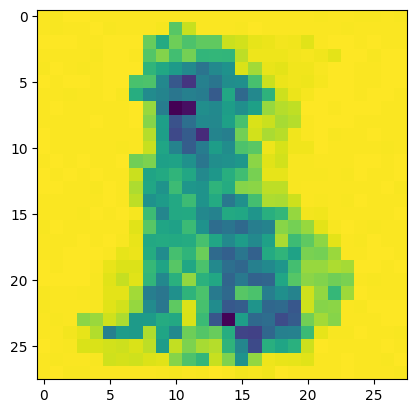

In [39]:
reconstructed_image = reconstruction[0].detach().cpu().numpy()
reconstructed_image = reconstructed_image.reshape(img_width, img_height)
plt.imshow(reconstructed_image)